#LLM Authorship Attribution

**Description:** This script can be used to train a custom LLM authorship classification model that we developped based on codeT5 770M

#STEP 0: Download dataset and install dependencies

In [1]:

print("[*] Installing dependencies...")
!pip install lizard > /dev/null 2>&1
!pip install --upgrade transformers > /dev/null 2>&1
print("[*] Installation: DONE")
print("[*] Loading packages...")
import random, string, re, os, json, lizard, tempfile
#import openai #Oritinal OpenAI
import pandas as pd
from collections import Counter
from tqdm import tqdm
from threading import Lock
import matplotlib.pyplot as plt
from transformers import BertTokenizer
import numpy as np
print("[*] Load: DONE")
print("[*] Downloading LLM-AuthorBench dataset with 32.000 compilable C program")
!wget -O LLM-AuthorBench.json.zip https://github.com/LLMauthorbench/LLMauthorbench/raw/main/LLM-AuthorBench.json.zip > /dev/null 2>&1
# Unzip the file
!unzip LLM-AuthorBench.json.zip > /dev/null 2>&1
# Delete the zip file
!rm LLM-AuthorBench.json.zip > /dev/null 2>&1
print("[*] Download: DONE")
# Read JSON data from file
with open('/content/LLM-AuthorBench.json', 'r') as file:
    data = json.load(file)
# Convert JSON data to DataFrame
balanced_df = pd.DataFrame(data)

[*] Installing dependencies...
[*] Installation: DONE
[*] Loading packages...
[*] Load: DONE
[*] Downloading LLM-AuthorBench dataset with 32.000 compilable C program
[*] Download: DONE


# STEP 1: C program Distribution

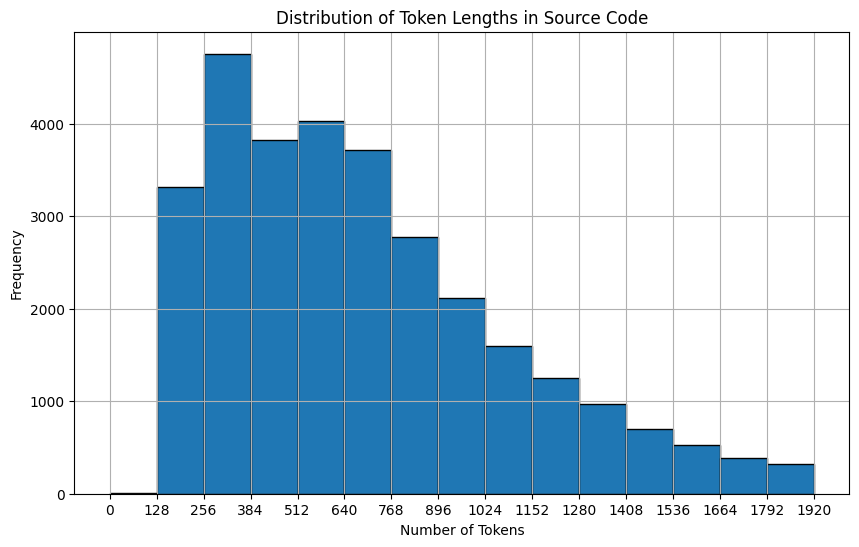

In [2]:
distribution = balanced_df['token_size'].describe()
bins = np.arange(0, 2000, 128)
plt.figure(figsize=(10, 6))
plt.hist(balanced_df['token_size'], bins=bins, edgecolor='black')
plt.title('Distribution of Token Lengths in Source Code')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.xticks(bins)
plt.grid(True)
plt.show()


#STEP 2: CodeT5 LLM authorship training (5-class multi classification)

In [5]:
# Load the codeT5 model and define the LLM authorship model structure
from torch.optim import lr_scheduler
import transformers
import torch
from torch.nn import CrossEntropyLoss
from transformers.modeling_outputs import SequenceClassifierOutput

def load_tokenizer():
    tokenizer = transformers.AutoTokenizer.from_pretrained("Salesforce/codet5p-770m")
    return tokenizer


def load_model(model_name):

    print(f'Loading  model {model_name}...')


    model_kwargs = {}

    model_kwargs.update(dict( torch_dtype=torch.bfloat16))
    #model_kwargs.update()
    transformers.T5EncoderModel._keys_to_ignore_on_load_unexpected = ["decoder.*"]
    model_encoder = transformers.T5EncoderModel.from_pretrained("Salesforce/codet5p-770m", **model_kwargs)

    print("---MODEL LOADED---")



    return model_encoder



class codeT5_Authorship(torch.nn.Module):
    def __init__(self,pretrained_encoder,dimensionality):
        super(codeT5_Authorship, self).__init__()
        self.modelBase = pretrained_encoder
        self.pre_classifier = torch.nn.Linear(dimensionality, 768, dtype=torch.bfloat16)
        self.activation = torch.nn.GELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 5, dtype=torch.bfloat16)
        self.loss_fn = CrossEntropyLoss()




    def forward(self, input_ids, padding_mask, labels=None):
        output_1 = self.modelBase(input_ids=input_ids, attention_mask=padding_mask)
        hidden_state = output_1[0]
        cls_output = hidden_state[:, 0]
        pooler = self.pre_classifier(cls_output)
        afterActivation = self.activation(pooler)
        pooler_after_act = self.dropout(afterActivation)
        logits = self.classifier(pooler_after_act)
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

def adapt_model(model, dim=1024):

    newModel = codeT5_Authorship(model,dimensionality=dim)

    return newModel

In [6]:
# Download codeT5 model and set the training parameters
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

model_name = "Salesforce/codet5p-770m"
encoder = LabelEncoder()

filtered_df = balanced_df[balanced_df['model_name'].isin(['gpt-4.1', 'deepseek-chat','claude-3.5-haiku','gemini-2.5-flash-preview-05-20','llama-3.3-70b-instruct'])].copy()

# Encode model names as binary labels
filtered_df['model_class'] = encoder.fit_transform(filtered_df['model_name'])

# Split the dataset (use stratify to preserve class balance)
train_df, test_df = train_test_split(filtered_df,test_size=0.2,random_state=42, stratify=filtered_df['model_class'])

# Load tokenizer and codeT5 model for 5-class classification
tokenizer = load_tokenizer()
#loading model and tokenizer for functional translation
model = load_model(model_name)
#adding classification head to the model
model = adapt_model(model, dim=model.shared.embedding_dim)


# Define dataset class
class CSourceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=1024):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
      row = self.data.iloc[index]
      prompt = str(row['prompt'])
      LLM=str(row['model_name'])
      code = str(row['c_code'])
      combined_text = (f"code: {code}")

      inputs = self.tokenizer.encode_plus(
          combined_text,
          add_special_tokens=True,
          max_length=self.max_len,
          padding='max_length',
          return_token_type_ids=True,
          truncation=True,
          return_attention_mask=True
      )

      return {
          'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
          'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
          'padding_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
          'labels': torch.tensor(row['model_class'], dtype=torch.long)
      }

    def __len__(self):
        return len(self.data)

# Prepare datasets
train_dataset = CSourceDataset(train_df, tokenizer)
test_dataset = CSourceDataset(test_df, tokenizer)

# Define metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments (remove invalid key)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    warmup_steps=200,
    weight_decay=0.01,
    report_to="none",
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    learning_rate=5e-5,
    lr_scheduler_type='cosine_with_restarts',
    warmup_ratio=0.1,
    save_safetensors=False,
)

Loading  model Salesforce/codet5p-770m...
---MODEL LOADED---


In [7]:
import torch
torch.cuda.empty_cache()

In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)
# Train the model
trainer.train()
trainer.evaluate()

In [ ]:
trainer.evaluate()

{'eval_loss': 0.1751832216978073,
 'eval_accuracy': 0.954,
 'eval_f1': 0.9541161314057667,
 'eval_precision': 0.9543959164085987,
 'eval_recall': 0.954,
 'eval_runtime': 108.1023,
 'eval_samples_per_second': 37.002,
 'eval_steps_per_second': 9.25,
 'epoch': 10.0}

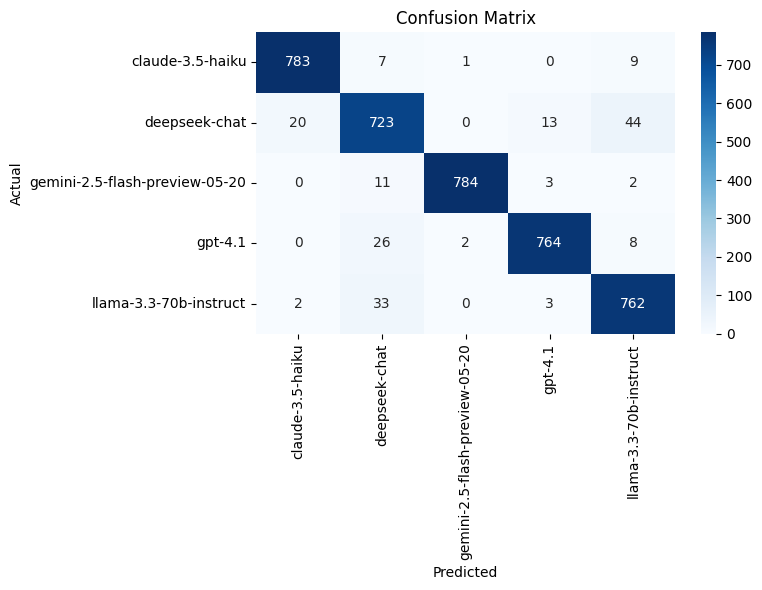

In [ ]:
#Visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions from the trainer
predictions = trainer.predict(test_dataset)

# Extract predicted labels
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Get class names from the LabelEncoder
encoder = LabelEncoder()
encoder.fit(filtered_df['model_name'])  # or use the original encoder if stored

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.pdf')
plt.show()


In [ ]:
trainer.save_model("./T5_llm_authorship_gelu")